# Hierachical Model

### Load Processed Train/Test

In [1]:
!pip install pymc

In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import os
import pickle
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

train_path = "/content/drive/My Drive/Bayesian_Project/train.csv"
test_path = "/content/drive/My Drive/Bayesian_Project/test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

Mounted at /content/drive


## Further Process dataset

In [4]:
# Standardize `Years_Employed` make that becomes numerical variable now
scaler = StandardScaler()
df_train["Years_Employed"] = scaler.fit_transform(df_train[["Years_Employed"]])
df_test["Years_Employed"] = scaler.transform(df_test[["Years_Employed"]])

# Drop the State column due to computation issue
df_train.drop(columns=["State"], inplace=True)
df_test.drop(columns=["State"], inplace=True)

In [5]:
df_train.head()

,Interest_Rate,Loan_Amount_Requested,Number_of_Payments,Years_Employed,Annual_Income,Income_Verified,Loan_Category,Debt_to_Income_Ratio,Delinquencies_2Y,Credit_Inquiries_6M,Derogatory_Public_Records,Total_Credit_Revolving_Balance,Revolving_Utilization_Rate,Total_Credit_Lines,Initial_Listing_Status,Days_Between_X15_X23,Funded_to_Requested_Ratio,Loan_to_Income_Ratio,Active_Credit_Line_Ratio
0,12.12,0.653888,1,-0.845673,0.754974,0,4,-0.530104,-0.333534,-0.783783,-0.250851,0.767728,0.220724,-0.377620,0,1.183949,0.084002,-0.336270,-0.543773
1,11.14,0.752423,0,-1.165628,-0.000577,2,2,-0.664851,-0.333534,-0.783783,-0.250851,0.271488,1.030576,-1.002825,0,-0.283561,0.084002,0.583870,-0.505864
2,17.27,-0.725600,0,1.713966,-0.306881,1,2,-0.914530,-0.333534,-0.783783,-0.250851,0.052635,0.852904,-0.466935,0,-1.269577,0.084002,-0.630514,-0.772283
3,7.62,-0.627065,0,0.434146,-0.286461,1,11,-1.386145,-0.333534,0.178156,-0.250851,-0.832042,-2.345186,-0.734880,0,-0.666812,0.084002,-0.529315,-0.088861
4,14.65,2.599952,1,-0.845673,-0.204780,0,6,-1.121935,-0.333534,0.178156,-0.250851,-0.034853,-0.175939,-0.198990,0,0.570387,0.084002,3.160687,0.745145


In [6]:
df_train.shape, df_test.shape

((161620, 19), (40405, 19))

## Forward selection to keep only necessary features

In [7]:
# Target variable
y_train = df_train["Interest_Rate"]

# Combine numerical and encoded categorical features
all_features = df_train.columns.difference(["Interest_Rate"]).tolist()

# Forward Selection using BIC
selected_features = []
best_bic = np.inf

print("🔍 Running Forward Selection with BIC...")

for feature in tqdm(all_features, desc="Feature Selection"):
    current_features = selected_features + [feature]
    X_train_subset = df_train[current_features]

    # Add constant for intercept
    X_train_subset = sm.add_constant(X_train_subset)

    # Fit OLS Model
    model = sm.OLS(y_train, X_train_subset).fit()

    # Compute BIC
    bic_score = model.bic

    # Keep feature if BIC improves
    if bic_score < best_bic:
        best_bic = bic_score
        selected_features.append(feature)

print("\n🎯 Final Selected Features:", selected_features)


🔍 Running Forward Selection with BIC...


Feature Selection: 100%|██████████| 18/18 [00:02<00:00,  6.01it/s]


🎯 Final Selected Features: ['Active_Credit_Line_Ratio', 'Credit_Inquiries_6M', 'Days_Between_X15_X23', 'Debt_to_Income_Ratio', 'Delinquencies_2Y', 'Derogatory_Public_Records', 'Funded_to_Requested_Ratio', 'Income_Verified', 'Loan_Amount_Requested', 'Loan_Category', 'Loan_to_Income_Ratio', 'Number_of_Payments', 'Revolving_Utilization_Rate', 'Total_Credit_Lines', 'Total_Credit_Revolving_Balance']


## Prepare Training data

In [8]:
# Prepare data
X_train = df_train[selected_features].values

# Encode categorical variables
loan_category = df_train["Loan_Category"].values
income_verified = df_train["Income_Verified"].values
number_of_payments = df_train["Number_of_Payments"].values

# Unique categories for hierarchical modeling
num_loan_categories = len(np.unique(loan_category))
num_income_verified = len(np.unique(income_verified))
num_number_of_payments = len(np.unique(number_of_payments))


## HBM Model - baseline

In [23]:
# Model Path
model_path = "/content/drive/My Drive/Bayesian_Project/hm_model.pkl"

if os.path.exists(model_path):
    print("Model found, loading existing trace...")
    with open(model_path, "rb") as f:
        trace = pickle.load(f)
else:
    print("Training Hierarchical Bayesian Model...")

    with pm.Model() as hierarchical_model:
        mu_0 = pm.Normal("mu_0", 10, 2)

        # Hierarchical Priors for Categorical Variables
        tau_loan_category = pm.HalfNormal("tau_loan_category", 3)
        tau_income_verified = pm.HalfNormal("tau_income_verified", 3)
        tau_number_of_payments = pm.HalfNormal("tau_number_of_payments", 3)

        mu_loan_category = pm.Normal("mu_loan_category", mu_0, tau_loan_category, shape=num_loan_categories)
        mu_income_verified = pm.Normal("mu_income_verified", mu_0, tau_income_verified, shape=num_income_verified)
        mu_number_of_payments = pm.Normal("mu_number_of_payments", mu_0, tau_number_of_payments, shape=num_number_of_payments)

        # Coefficients for Selected Numerical Features
        beta = pm.Normal("beta", 0, 1, shape=len(selected_features))

        # Noise term
        sigma = pm.HalfNormal("sigma", 5)

        # Expected Interest Rate
        mu = (
            mu_loan_category[loan_category] +
            mu_income_verified[income_verified] +
            mu_number_of_payments[number_of_payments] +
            pm.math.dot(X_train, beta)
        )

        # Likelihood
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

        # Use MAP Optimization for Better Initialization
        start = pm.find_MAP()

        # Use NumPyro Sampler for Faster Convergence
        print("Running Fast NumPyro Sampler...")
        trace = pm.sample(draws=300, tune=150, chains=1, cores=1, target_accept=0.9, sampler="numpyro", start=start)

    # Save Model
    with open(model_path, "wb") as f:
        pickle.dump(trace, f)

    print(f"Model trained and saved at {model_path}")


Training Hierarchical Bayesian Model...


Output()

Running Fast NumPyro Sampler...


<ipython-input-23-5e60e60e0e63>:45: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(draws=300, tune=150, chains=1, cores=1, target_accept=0.9, sampler="numpyro", start=start)


Output()

Model trained and saved at /content/drive/My Drive/Bayesian_Project/hm_model.pkl


## Transform Test set and make prediction

In [9]:
# Model Path
model_path = "/content/drive/My Drive/Bayesian_Project/hm_model.pkl"


with open(model_path, "rb") as f:
        trace = pickle.load(f)

In [10]:
## Change test
y_test = df_test["Interest_Rate"].values
X_test = df_test[selected_features].values

loan_category_test = pd.factorize(df_test["Loan_Category"])[0]
income_verified_test = pd.factorize(df_test["Income_Verified"])[0]
number_of_payments_test = pd.factorize(df_test["Number_of_Payments"])[0]

In [11]:
## y_pred
mu_0_mean = trace.posterior["mu_0"].mean(dim=["chain", "draw"]).item()
mu_loan_category_mean = trace.posterior["mu_loan_category"].mean(dim=["chain", "draw"]).values
mu_income_verified_mean = trace.posterior["mu_income_verified"].mean(dim=["chain", "draw"]).values
mu_number_of_payments_mean = trace.posterior["mu_number_of_payments"].mean(dim=["chain", "draw"]).values
beta_mean = trace.posterior["beta"].mean(dim=["chain", "draw"]).values

predicted_interest_rate = (
    mu_0_mean +
    mu_loan_category_mean[loan_category_test] +
    mu_income_verified_mean[income_verified_test] +
    mu_number_of_payments_mean[number_of_payments_test] +
    np.dot(X_test, beta_mean)
)

## Evaluation

In [12]:
# Compute Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, predicted_interest_rate))
mae = mean_absolute_error(y_test, predicted_interest_rate)
mse = mean_squared_error(y_test, predicted_interest_rate)
r2 = r2_score(y_test, predicted_interest_rate)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 6.4487
MAE: 5.7300
MSE: 41.5861
R² Score: -1.1456


## Visualization

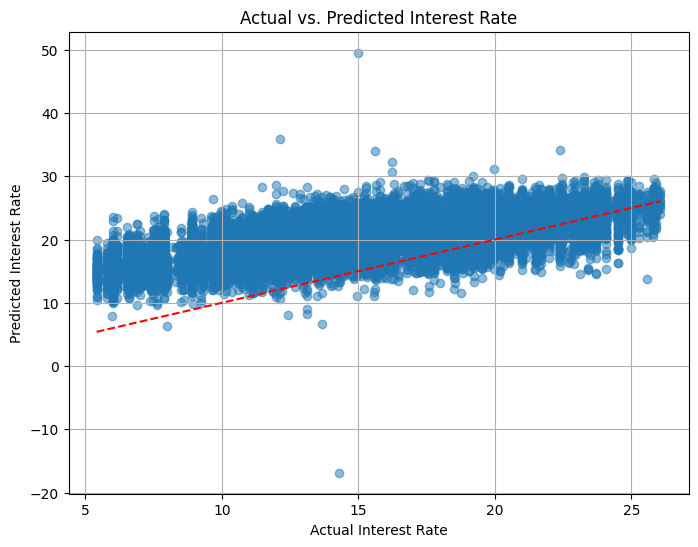

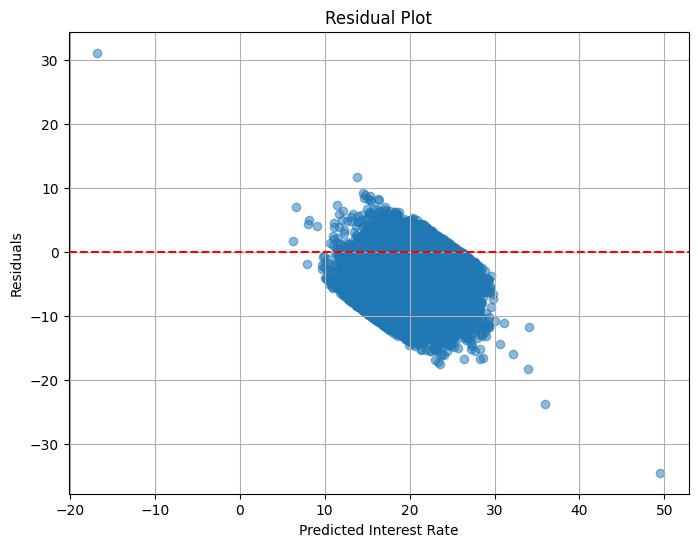

In [13]:
# Scatter Plot: Actual vs. Predicted Interest Rates
plt.figure(figsize=(8,6))
plt.scatter(y_test, predicted_interest_rate, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="--")
plt.xlabel("Actual Interest Rate")
plt.ylabel("Predicted Interest Rate")
plt.title("Actual vs. Predicted Interest Rate")
plt.grid()
plt.show()

## Residual
residuals = y_test - predicted_interest_rate
plt.figure(figsize=(8,6))
plt.scatter(predicted_interest_rate, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle="--")
plt.xlabel("Predicted Interest Rate")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid()
plt.show()

Output()

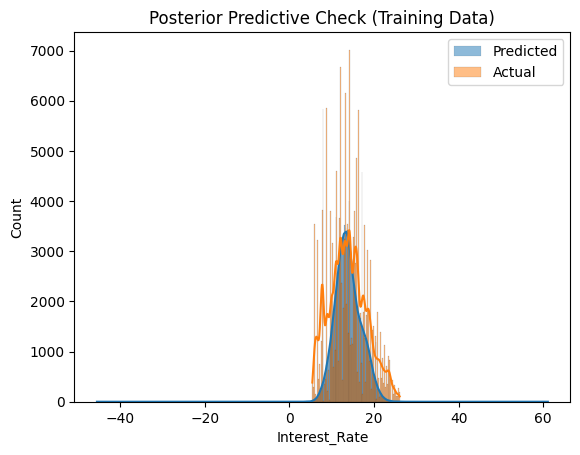

In [24]:
# Rebuild the model structure before running posterior predictive checks
with pm.Model() as hierarchical_model:
    mu_0 = pm.Normal("mu_0", 10, 2)

    tau_loan_category = pm.Exponential("tau_loan_category", 1)
    tau_income_verified = pm.Exponential("tau_income_verified", 1)
    tau_number_of_payments = pm.Exponential("tau_number_of_payments", 1)

    mu_loan_category = pm.Normal("mu_loan_category", mu_0, tau_loan_category, shape=len(np.unique(loan_category)))
    mu_income_verified = pm.Normal("mu_income_verified", mu_0, tau_income_verified, shape=len(np.unique(income_verified)))
    mu_number_of_payments = pm.Normal("mu_number_of_payments", mu_0, tau_number_of_payments, shape=len(np.unique(number_of_payments)))

    beta = pm.Normal("beta", 0, 2, shape=len(selected_features))
    sigma = pm.HalfNormal("sigma", 2)

    mu = (
        mu_loan_category[loan_category] +
        mu_income_verified[income_verified] +
        mu_number_of_payments[number_of_payments] +
        pm.math.dot(X_train, beta)
    )

    # Define the likelihood (this creates `y_obs`)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

    # Now sample posterior predictive checks
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"])

# Plot posterior predictive results
sns.histplot(ppc.posterior_predictive["y_obs"].mean(dim=["chain", "draw"]).values.flatten(), kde=True, label="Predicted")
sns.histplot(df_train["Interest_Rate"], kde=True, label="Actual")
plt.legend()
plt.title("Posterior Predictive Check (Training Data)")
plt.show()

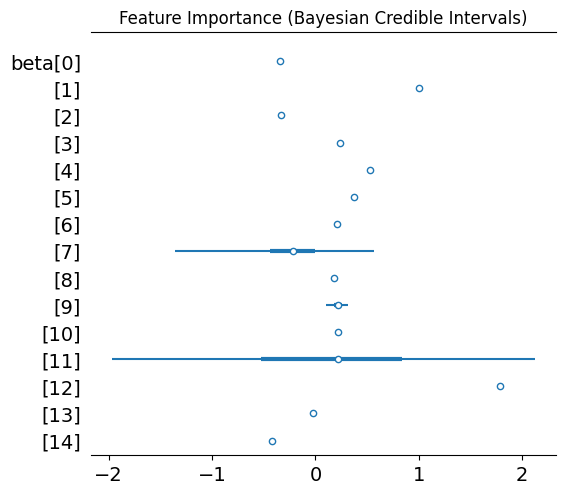

In [15]:
import arviz as az

# Plot credible intervals for coefficients
az.plot_forest(trace, var_names=["beta"], combined=True)
plt.title("Feature Importance (Bayesian Credible Intervals)")
plt.show()